#### *Dataset Description*

**Score**: Ranging from 1 - 10 (can't be 0)

**Watching Status**
- 1: Currently Watching
- 2: Completed
- 3: On Hold
- 4: Dropped
- 6: Plan to Watch

### Loading

In [ ]:
# USERS_PAGE + CLUBS_PAGE
!gdown 'LINK_REMOVED'
!wc -l 'dumps.csv'

#### Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [ ]:
plt.rcParams["figure.figsize"] = (9, 6)

In [ ]:
RATING_PATH = 'dumps.csv'
ratings = pd.read_csv(RATING_PATH)

In [ ]:
ratings.head()

,username,type,id,title,score,status
0,Blaziken,anime,4151,Blade of the Immortal,7,1
1,Blaziken,anime,1,Cowboy Bebop,8,1
2,Blaziken,anime,6702,Fairy Tail,8,1
3,Blaziken,anime,11061,Hunter x Hunter (2011),9,1
4,Blaziken,anime,8277,Hyakka Ryouran: Samurai Girls,7,1


### Cleaning

In [ ]:
ratings.shape, ratings.username.nunique(), ratings.title.nunique()

((8724217, 6), 18527, 64624)

In [ ]:
ratings.status.value_counts()

2    4833882
6    2566712
1     689398
3     344834
4     289363
0         28
Name: status, dtype: int64

In [ ]:
# 1) the status `0` is probably an error on the site, get rid of it
ratings = ratings[ratings.status != 0].copy()
ratings.status.value_counts()

2    4833882
6    2566712
1     689398
3     344834
4     289363
Name: status, dtype: int64

In [ ]:
# 2) encode status as category
ratings.status = ratings.status.astype('category')

In [ ]:
# 3) remove duplicated entries
# (possible cause: my fault when storing scraped data)
ratings[ratings.duplicated()]

,username,type,id,title,score,status
4913277,Yumerei,anime,6547,Angel Beats!,0,1
4913279,Yumerei,anime,14751,Bishoujo Senshi Sailor Moon Crystal,0,1
4913280,Yumerei,anime,31964,Boku no Hero Academia,0,1
4913281,Yumerei,anime,37379,Chihayafuru 3,0,1
4913282,Yumerei,anime,47413,Detective Conan: The Scarlet Alibi,0,1
...,...,...,...,...,...,...
8714299,PHANTOM_07,manga,87610,Tensei shitara Slime Datta Ken,8,3
8714300,PHANTOM_07,manga,123992,Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu ...,8,3
8714301,PHANTOM_07,manga,35243,Haikyuu!!,0,6
8714302,PHANTOM_07,manga,1325,Hi no Tori (1967),0,6


In [ ]:
ratings.loc[(ratings.username == 'Yumerei') & (ratings.title == 'Angel Beats!')]

,username,type,id,title,score,status
2620755,Yumerei,anime,6547,Angel Beats!,0,1
4913277,Yumerei,anime,6547,Angel Beats!,0,1


In [ ]:
# look the comparison between non-duplicated and duplicated
ratings.shape, ratings[ratings.duplicated()].shape, ratings[~ratings.duplicated()].shape

((8724189, 6), (136296, 6), (8587893, 6))

In [ ]:
ratings = ratings[~ratings.duplicated()]
ratings.shape

(8587893, 6)

In [ ]:
# assuming the ratings has been deduplicated & ratings_clean cell has been ran
any(ratings.duplicated())

False

In [ ]:
# 4) clean the dataset from 0 ratings (including plan-to-watch status)

# ratings with score 0
ratings.loc[ratings.score == 0].shape

(4073966, 6)

In [ ]:
# clean them
ratings_clean = ratings.loc[ratings.score != 0].copy()

# resort the index
ratings_clean.index = pd.RangeIndex(0, len(ratings_clean))

ratings_clean.shape

(4513927, 6)

In [ ]:
# 5) duplicate in title: Manga & LN are regarded as one category in the site
# pick the highest one among the two as the rating using max
# https://stackoverflow.com/a/51459733/8996974

In [ ]:
any(ratings_clean.duplicated(subset=['username', 'type', 'title']))

True

In [ ]:
# there's duplicate with different score given
sum(ratings_clean.duplicated(subset=['username', 'type', 'title'])), sum(ratings_clean.duplicated(subset=['username', 'type', 'title', 'score']))

(8115, 3263)

In [ ]:
# example of such duplicates
# https://myanimelist.net/manga/57201
# https://myanimelist.net/manga/70061
f = (ratings_clean.username == 'BlueAtomix') & \
    (ratings_clean['type'] == 'manga') & \
    (ratings_clean.title == 'Rakudai Kishi no Cavalry')

ratings_clean[f]

,username,type,id,title,score,status
2668639,BlueAtomix,manga,57201,Rakudai Kishi no Cavalry,10,1
2668676,BlueAtomix,manga,70061,Rakudai Kishi no Cavalry,10,2


In [ ]:
# shape before dropping duplicates
ratings_clean.shape

(4513927, 6)

In [ ]:
ratings_clean = ratings_clean.sort_values('score') \
                             .drop_duplicates(['username', 'type', 'title'],
                                              keep='last')

# shape after dropping duplicates
ratings_clean.shape

(4505812, 6)

### EDA

##### Basic numerics

In [ ]:
# 3.915.953 entries
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8587893 entries, 0 to 8724216
Data columns (total 6 columns):
 #   Column    Dtype   
---  ------    -----   
 0   username  object  
 1   type      object  
 2   id        int64   
 3   title     object  
 4   score     int64   
 5   status    category
dtypes: category(1), int64(2), object(3)
memory usage: 401.3+ MB


In [ ]:
# number of unique users: 10.117
ratings.username.nunique()

18527

In [ ]:
# number of unique titles: 57.561
ratings.title.nunique()

64624

In [ ]:
# actually rated titles: 1.933.280
len(ratings[ratings.score != 0])

1916059

##### Ratings, by users

In [ ]:
ratings.groupby('username')['score'].agg(['min', 'max', 'mean'])

,min,max,mean
username,,,
--ALEX--,0,10,6.296333
--Nightmare--,3,10,7.139630
--William--,0,10,4.753623
--Xerxes--,0,10,4.232804
-Arnheid-,0,10,7.039548
...,...,...,...
zyume,0,10,5.289720
zyxqupalef,0,10,4.926573
zztag146,0,0,0.000000


In [ ]:
# example of users who haven't rated anything, but have a list (cold start)
ratings[ratings.username == 'zztag146']

,username,type,id,title,score,status
3829685,zztag146,anime,41587,Boku no Hero Academia 5th Season,0,1
3829686,zztag146,anime,6702,Fairy Tail,0,1
3829687,zztag146,anime,20,Naruto,0,1
3829688,zztag146,anime,527,Pokemon,0,1
3829689,zztag146,anime,19291,Pokemon XY,0,1
3829690,zztag146,anime,16498,Shingeki no Kyojin,0,1
3829691,zztag146,anime,39195,Beastars,0,2
3829692,zztag146,anime,40935,Beastars 2nd Season,0,2
3829693,zztag146,anime,31964,Boku no Hero Academia,0,2
3829694,zztag146,anime,33486,Boku no Hero Academia 2nd Season,0,2


In [ ]:
# how many haven't rated anything?
sum(ratings.groupby('username')['score'].agg('mean') == 0)  # adding boolean value

979

##### Ratings vs. Ratings Clean

In [ ]:
ratings.username.nunique(), ratings.title.nunique()

(18527, 64624)

In [ ]:
# down 700 users, 20k titles
ratings_clean.username.nunique(), ratings_clean.title.nunique()

(17548, 47519)

##### Clean user scores

In [ ]:
ratings_clean.groupby('username')['score'].agg(['min', 'max', 'mean']).head()

,min,max,mean
username,,,
---DANIEL---,5,10,8.000000
---KING---,1,10,6.980707
---Spartacus---,9,9,9.000000
--ALEX--,1,10,6.875541
--ANONYMOUS--,3,10,7.141153


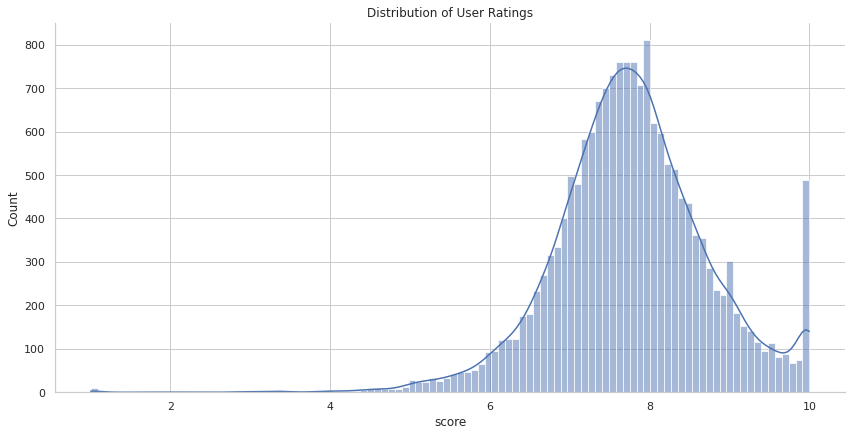

In [ ]:
# mean score distribution of the users, looks quite normal
mean_score = ratings_clean.groupby('username')['score'].agg('mean')

sns.displot(mean_score, height=6, aspect=2, kde=True).set(title='Distribution of User Ratings')

In [ ]:
# people who only rated 10
sum(mean_score == 10)

425

In [ ]:
mean_score.mean(), mean_score.std()

(7.770650870259337, 0.974098578515249)

[Text(0.5, 1.0, 'Outliers in the Distribution of User Ratings')]

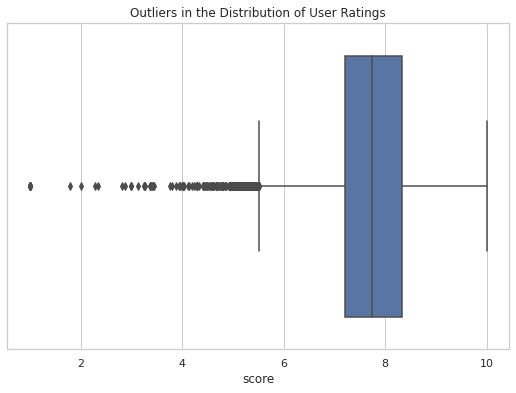

In [ ]:
 sns.boxplot(x = mean_score).set(title='Outliers in the Distribution of User Ratings')

##### Status

In [ ]:
ratings_clean.dtypes

username      object
type          object
id             int64
title         object
score          int64
status      category
dtype: object

In [ ]:
ratings_clean.status.value_counts()

2    1750545
1      85922
4      58887
3      30385
6       7541
0          0
Name: status, dtype: int64

[Text(0.5, 1.0, 'User Watching Status Proportion')]

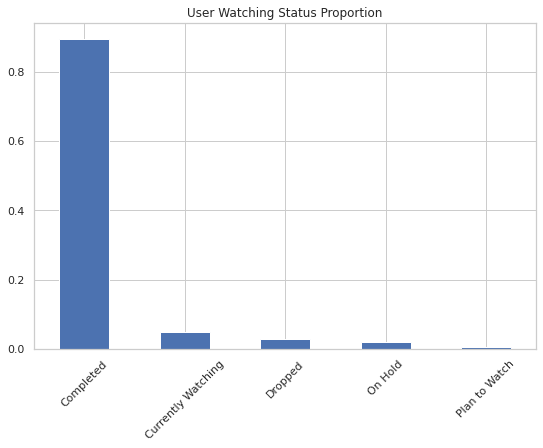

In [ ]:
status_counts = ratings_clean.status.value_counts(normalize=True)
map_index = {
    1: "Currently Watching",
    2: "Completed",
    3: "On Hold",
    4: "Dropped",
    6: "Plan to Watch",
}
status_counts.rename(map_index, inplace=True)
status_counts.plot.bar(rot=45).set(title='User Watching Status Proportion')

[Text(0.5, 1.0, 'User Watching Status Proportion in Uncleaned Data')]

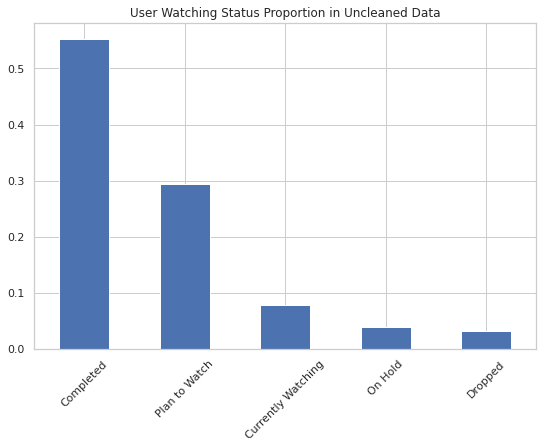

In [ ]:
# the uncleaned ratings has plan-to-watch status which has 0 has its score
# and there are more plan-to-watch there than the middle 3 status
uncleaned_status_counts = ratings.status.value_counts(normalize=True)
uncleaned_status_counts.rename(map_index, inplace=True)
uncleaned_status_counts.plot.bar(rot=45).set(title='User Watching Status Proportion in Uncleaned Data')

##### Title

In [ ]:
title_counts = ratings_clean.title.value_counts()
title_counts

Shingeki no Kyojin                                               14687
Death Note                                                       12797
Kimetsu no Yaiba                                                 11412
Boku no Hero Academia                                            11026
Naruto                                                           10598
                                                                 ...  
Sennen no Yakusoku                                                   1
Omiai Daisakusen!                                                    1
Sagami-san wa Nisemono: Daikirai na Osananajimi ni Dakaremasu        1
Are wa Choukouritsu no Mochako da yo!                                1
Senpai wa Kigae ga Dekinai                                           1
Name: title, Length: 47519, dtype: int64

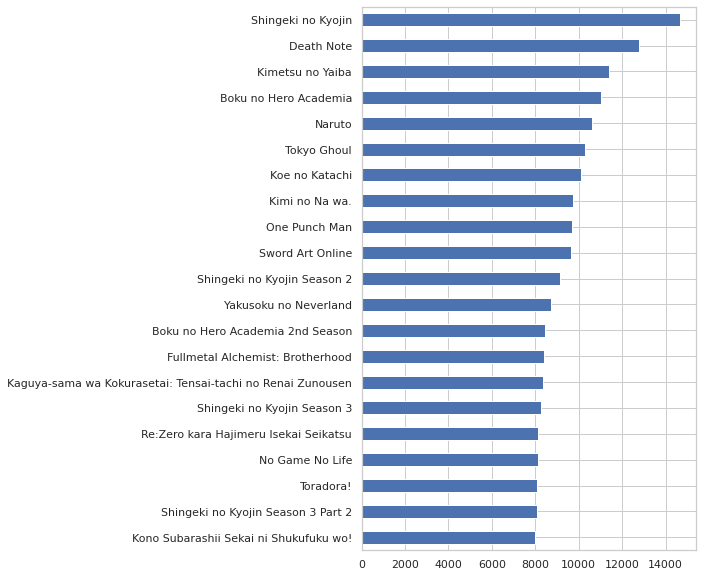

In [ ]:
title_counts[20::-1].plot.barh(figsize=(6,10))

[Text(0, 0.5, 'Amount of Ratings'),
 Text(0.5, 0, 'Item IDs'),
 Text(0.5, 1.0, 'Long Tail in the Item Ratings')]

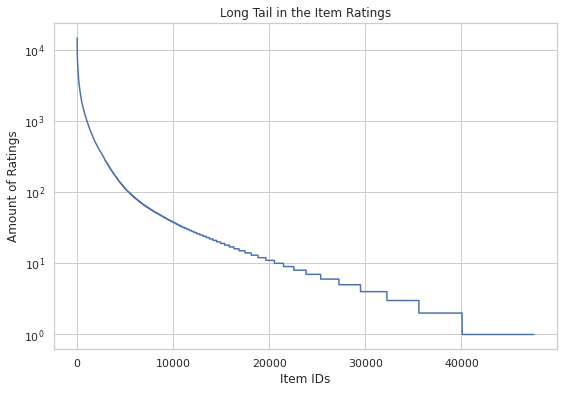

In [ ]:
# Visualize long tail
title_counts.plot.line(use_index=False, logy=True) \
                  .set(
                      title='Long Tail in the Item Ratings',
                      xlabel='Item IDs',
                      ylabel='Amount of Ratings'
                  )

##### Manga x Anime

[Text(0.5, 1.0, 'Rating Proportion between Anime and Manga')]

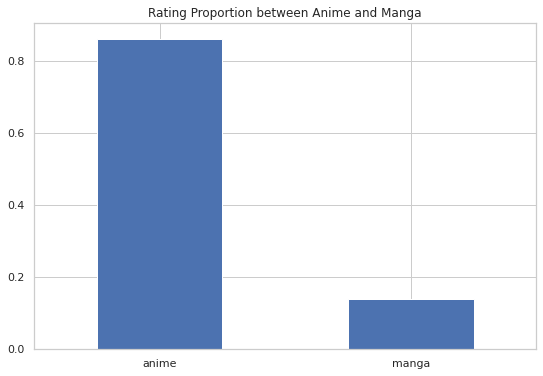

In [ ]:
ratings_clean['type'].value_counts(normalize=True) \
                      .plot(kind='bar', rot=0) \
                      .set(title='Rating Proportion between Anime and Manga')

In [ ]:
manga = ratings_clean[ratings_clean['type'] == 'manga']
anime = ratings_clean[ratings_clean['type'] == 'anime']

In [ ]:
len(manga), len(manga) / len(ratings_clean)  # proportion of manga in clean dataset

(196829, 0.10285006325287512)

In [ ]:
len(anime), len(anime) / len(ratings_clean)  # proportion of anime in clean dataset

(1716918, 0.8971499367471248)

In [ ]:
total_anime = anime.title.nunique()
total_manga = manga.title.nunique()
total_titles = anime.title.nunique() + manga.title.nunique()

total_anime, total_manga, total_anime / total_titles, total_manga / total_titles

(17051, 32717, 0.34260970904999194, 0.657390290950008)

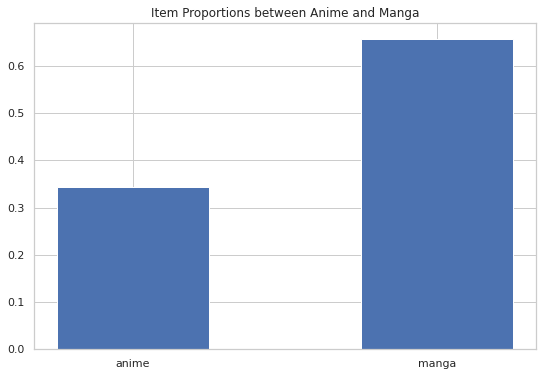

In [ ]:
plt.bar(x = ['anime', 'manga'],
        height = [total_anime / total_titles, total_manga / total_titles],
        width = .5
      )
plt.title('Item Proportions between Anime and Manga')
plt.show()

In [ ]:
manga_counts = manga.title.value_counts()
manga_counts

Shingeki no Kyojin     1860
Chainsaw Man           1799
Kimetsu no Yaiba       1228
Solo Leveling          1073
Tokyo Ghoul            1025
                       ... 
M.M Santa                 1
Fizon Core                1
Mou Manzoku desho!?       1
S-senjou no Tena          1
Vetsunova                 1
Name: title, Length: 23154, dtype: int64

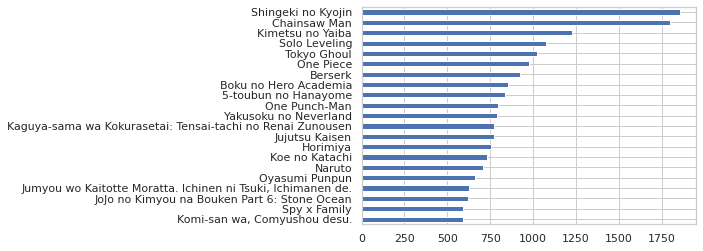

In [ ]:
manga_counts[20::-1].plot.barh()

In [ ]:
anime_counts = anime.title.value_counts()
anime_counts

Kimetsu no Yaiba                                  6404
Shingeki no Kyojin                                6309
Boku no Hero Academia                             5663
Shingeki no Kyojin Season 2                       5653
Kimi no Na wa.                                    5647
                                                  ... 
A-jang.com                                           1
Hello Kitty no Yappari Mama ga Suki                  1
Sore Ike! Anpanman: Yumeneko no Kuni no Nyanii       1
Naniwa Yuukyouden: Kanketsu-hen                      1
Maboroshi Mabo-chan                                  1
Name: title, Length: 16136, dtype: int64

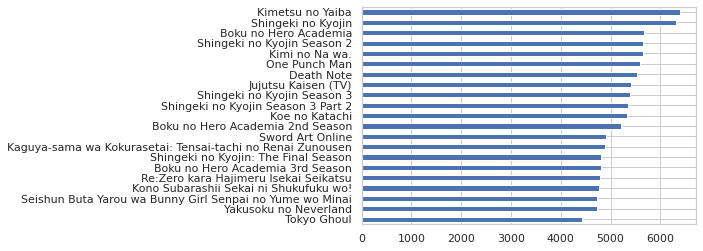

In [ ]:
anime_counts[20::-1].plot.barh()

In [ ]:
manga.groupby('title')['score'].agg(['min', 'max', 'mean'])

,min,max,mean
title,,,
"""1999""",3,4,3.500000
"""Aishiteru"", Uso dakedo.",7,7,7.000000
"""Aoi"" Hikaru ga Chikyuu ni Ita Koro......",5,10,7.538462
"""Boku wa Senpai ni Josou wo Shiirareteimasu.""",1,7,5.000000
"""Bungaku Shoujo"" Series",6,9,7.200000
...,...,...,...
♀x♀=♥,6,9,7.500000
♂Docchi♀,4,6,5.250000
♡♡♡ suru Onnanoko,4,4,4.000000


In [ ]:
anime.groupby('title')['score'].agg(['min', 'max', 'mean'])

,min,max,mean
title,,,
"""0""",1,7,4.187500
"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",3,10,6.457143
"""Bungaku Shoujo"" Memoire",3,10,6.888889
"""Bungaku Shoujo"" Movie",2,10,6.946809
"""Calpis"" Hakkou Monogatari",1,5,2.857143
...,...,...,...
xxxHOLiC Movie: Manatsu no Yoru no Yume,4,10,7.587500
xxxHOLiC Rou,4,10,7.857143
xxxHOLiC Shunmuki,3,10,7.840909


In [ ]:
# visualize long tail

[Text(0, 0.5, 'Amount of Ratings'),
 Text(0.5, 0, 'IDs'),
 Text(0.5, 1.0, 'Long Tail in Manga Ratings')]

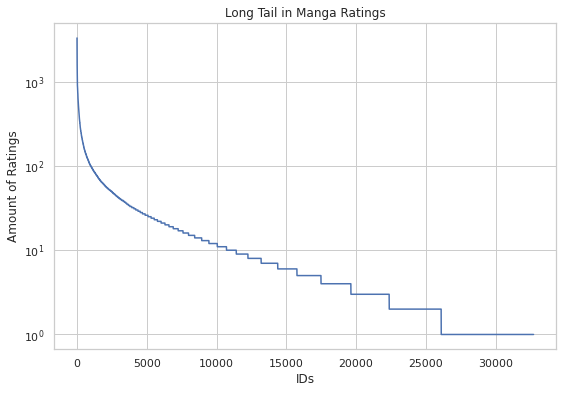

In [ ]:
manga.title.value_counts().plot \
                          .line(use_index=False, logy=True) \
                          .set(title='Long Tail in Manga Ratings',
                               xlabel='IDs',
                               ylabel='Amount of Ratings')

[Text(0, 0.5, 'Amount of Ratings'),
 Text(0.5, 0, 'IDs'),
 Text(0.5, 1.0, 'Long Tail in Anime Ratings')]

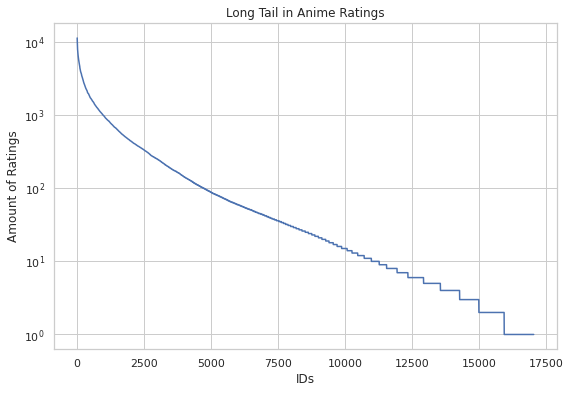

In [ ]:
# sns.displot(x=anime.title.value_counts(), bins=50, height=6, aspect=2, log_scale=(False, True))
anime.title.value_counts().plot \
                          .line(use_index=False, logy=True) \
                          .set(title='Long Tail in Anime Ratings',
                               xlabel='IDs',
                               ylabel='Amount of Ratings')

In [ ]:
# mean rating of anime & manga, and its std dev.
# displot & boxplot

In [ ]:
manga.score.mean(), manga.score.std()

(7.413302328098415, 1.7676259421506355)

[Text(0.5, 1.0, 'Distribution of Manga Ratings')]

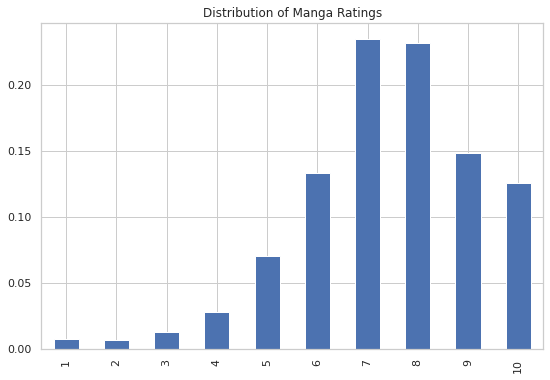

In [ ]:
# score by user
manga.score.value_counts(normalize=True) \
            .sort_index() \
            .plot.bar() \
            .set(title='Distribution of Manga Ratings')

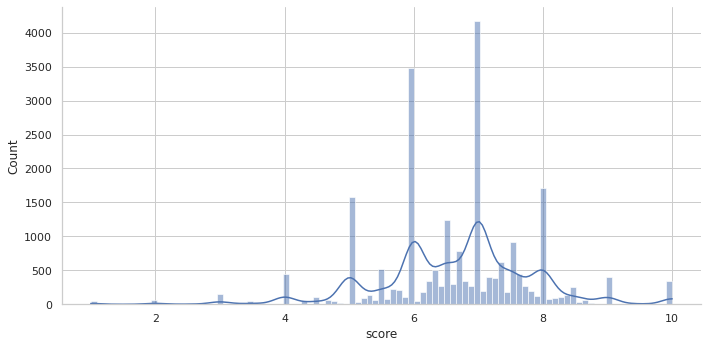

In [ ]:
# score by title
sns.displot(x = manga.groupby('title')['score'].mean(), height=5, aspect=2, kde=True)

[Text(0.5, 1.0, 'Outliers in the Distribution of Manga Ratings')]

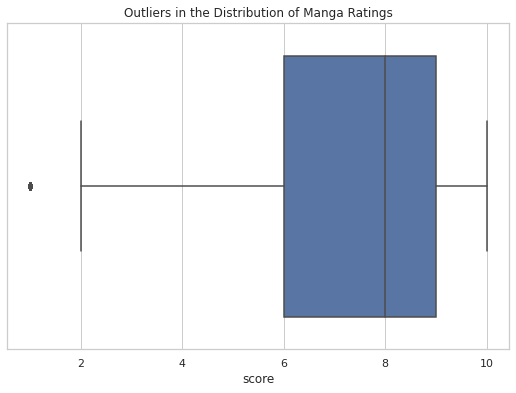

In [ ]:
sns.boxplot(x = manga.score) \
    .set(title='Outliers in the Distribution of Manga Ratings')

In [ ]:
anime.score.mean(), anime.score.std()

(7.267492661693985, 1.8328255446574022)

[Text(0.5, 1.0, 'Distribution of Anime Ratings')]

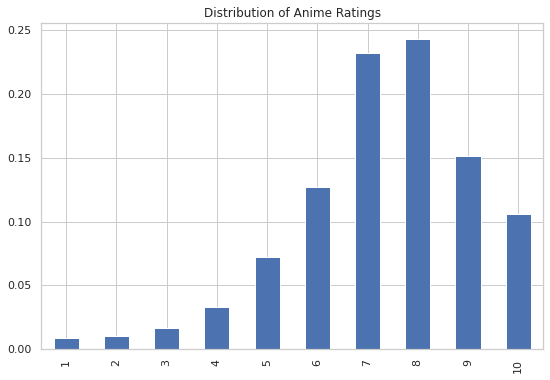

In [ ]:
# score by user
anime.score.value_counts(normalize=True) \
            .sort_index() \
            .plot.bar() \
            .set(title='Distribution of Anime Ratings')

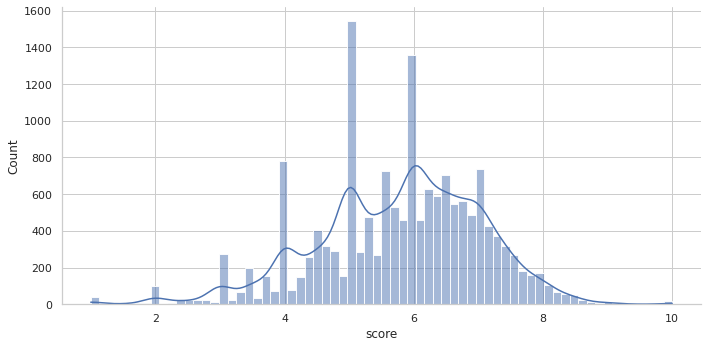

In [ ]:
sns.displot(x = anime.groupby('title')['score'].mean(), height=5, aspect=2, kde=True)

[Text(0.5, 1.0, 'Outliers in the Distribution of Anime Ratings')]

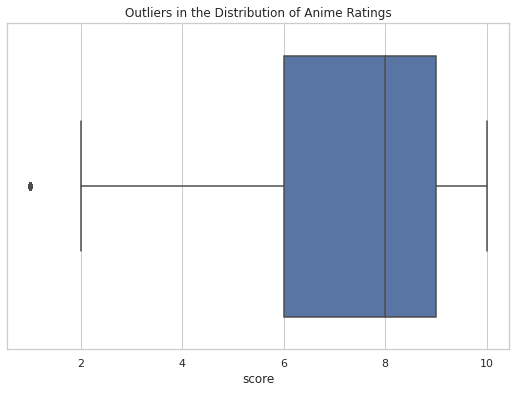

In [ ]:
sns.boxplot(x = anime.score) \
    .set(title='Outliers in the Distribution of Anime Ratings')

In [ ]:
# threshold values for manga/anime that has really low ratings?
# based on the mean of ratings user give?
# the lower bar was mean - std ~ 6.7

In [ ]:
# compare the distribution back-to-back

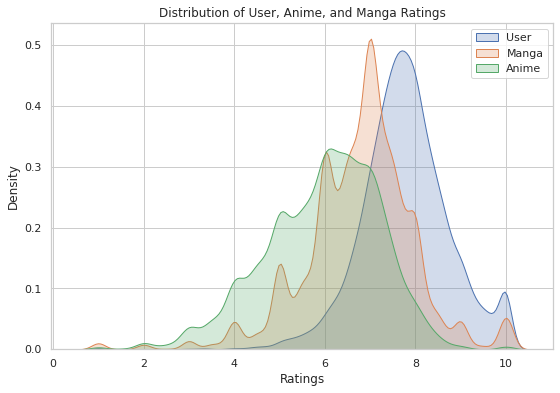

In [ ]:
sns.kdeplot(x=mean_score, shade=True, label='User')
sns.kdeplot(x=manga.groupby('title')['score'].mean(), shade=True, label='Manga')
sns.kdeplot(x=anime.groupby('title')['score'].mean(), shade=True, label='Anime')

plt.title("Distribution of User, Anime, and Manga Ratings")
plt.xlabel('Ratings')
plt.legend()

##### Sparsity

In [ ]:
manga.username.nunique(), manga.title.nunique(), len(manga)

(12719, 32717, 628281)

In [ ]:
len(manga) / len(ratings.loc[(ratings['type'] == 'manga')])  # 34% are rated

0.4059045620581786

In [ ]:
# sparsity, in %
manga_sparsity = (len(manga) / (manga.username.nunique() * manga.title.nunique())) * 100
manga_sparsity

0.15098280341336615

In [ ]:
anime.username.nunique(), anime.title.nunique(), len(anime)

(17445, 17051, 3877531)

In [ ]:
len(anime) / len(ratings.loc[(ratings['type'] == 'anime')])  # 51% are rated

0.5507826021986526

In [ ]:
# sparsity, in %
anime_sparsity = (len(anime) / (anime.username.nunique() * anime.title.nunique())) * 100
anime_sparsity

1.303570279837069

In [ ]:
print(f"Sparsity {100 - (manga_sparsity + anime_sparsity):.2f}%")

Sparsity 98.55%


##### Looking at weird-looking data

In [ ]:
# the "0" in status
zero_in_status =  ratings[ratings.status == 0]
zero_in_status.head()

"""
further investigation suggest that it might be an error, or "not classified" category
so, let's just drop this
"""

'\nfurther investigation suggest that it might be an error, or "not classified" category\nso, let\'s just drop this\n'

In [ ]:
# users that haven't rated anything but has lists
"""
investigation suggest that these people might have "private scores" on their profile page.
this answer is indicated by the high `completed` bar, higher than plan-to-watch, which if it's higher,
might actually explain that it's just issues in the status. but, no, as the `completed` status is higher,
and I checked on one of the profile, there's just no score to be seen on the lists.
"""

'\ninvestigation suggest that these people might have "private scores" on their profile page.\nthis answer is indicated by the high `completed` bar, higher than plan-to-watch, which if it\'s higher,\nmight actually explain that it\'s just issues in the status. but, no, as the `completed` status is higher,\nand I checked on one of the profile, there\'s just no score to be seen on the lists.\n'

In [ ]:
users_score = ratings.groupby('username')['score'].mean()
users_havent_rate = users_score[users_score == 0]
users_havent_rate

username
06hotdawg       0.0
100gecstou      0.0
1Kyo3           0.0
31915           0.0
4inxv           0.0
               ... 
yumenonaka12    0.0
zagaller        0.0
zerpiente       0.0
zoul_yusouf     0.0
zztag146        0.0
Name: score, Length: 729, dtype: float64

In [ ]:
users_havent_rate = ratings.merge(users_havent_rate, how='inner', on='username').drop(columns=['score_x', 'score_y', 'id'])
users_havent_rate

,username,type,title,status
0,AthulIsla,anime,5-toubun no Hanayome,2
1,AthulIsla,anime,Absolute Duo,2
2,AthulIsla,anime,Air,2
3,AthulIsla,anime,Akame ga Kill!,2
4,AthulIsla,anime,Akaneiro ni Somaru Saka,2
...,...,...,...,...
209236,MDLG,manga,Seishun Buta Yarou Series,6
209237,MDLG,manga,Shigatsu wa Kimi no Uso,6
209238,MDLG,manga,Solo Leveling,6
209239,MDLG,manga,Yahari Ore no Seishun Love Comedy wa Machigatt...,6


In [ ]:
users_havent_rate.describe()

,username,type,title,status
count,209241,209241,209241,209241
unique,729,2,16504,5
top,jGRite,anime,Kimetsu no Yaiba,2
freq,3971,184531,517,113584


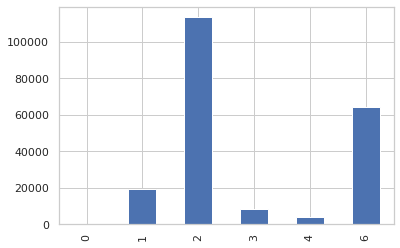

In [ ]:
users_havent_rate.status.value_counts().sort_index().plot.bar()

In [ ]:
# users that give all 10.0 for everything
"""
investigation suggest that these users are watching relatively highly rated titles (skew to the right),
which is easy to explain: they only watch good titles, and they liked it so much.
though, there's one anomalous user that rated 128 titles at 10.0; that's probably too much?
"""

"\ninvestigation suggest that these users are watching relatively highly rated titles (skew to the right),\nwhich is easy to explain: they only watch good titles, and they liked it so much.\nthough, there's one anomalous user that rated 128 titles at 10.0; that's probably too much?\n"

In [ ]:
users_rated_all_10 = users_score[users_score == 10]
users_rated_all_10.shape

(34,)

In [ ]:
users_rated_all_10 = ratings_clean.merge(users_rated_all_10, how='inner', on='username').drop(columns=['score_x', 'score_y', 'id'])
users_rated_all_10.head()

,username,type,title,status
0,085396231607,anime,Vanitas no Karte,1
1,KawaiiSensei,anime,Shigatsu wa Kimi no Uso,2
2,Edward17,anime,Haikyuu!!,2
3,Edward17,anime,Haikyuu!! Second Season,2
4,Edward17,anime,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa G...,2


In [ ]:
users_rated_all_10.describe()

,username,type,title,status
count,195,195,195,195
unique,34,2,162,3
top,eivanlopez,anime,Hunter x Hunter (2011),2
freq,128,188,3,173


In [ ]:
users_rated_all_10.title.value_counts()

Hunter x Hunter (2011)                  3
86                                      3
Shingeki no Kyojin: The Final Season    3
Fullmetal Alchemist: Brotherhood        3
Shingeki no Kyojin                      3
                                       ..
Shokugeki no Souma: Shin no Sara        1
Haikyuu!!: To the Top 2nd Season        1
Motto To LOVE-Ru                        1
Noragami                                1
Perfect Blue                            1
Name: title, Length: 162, dtype: int64

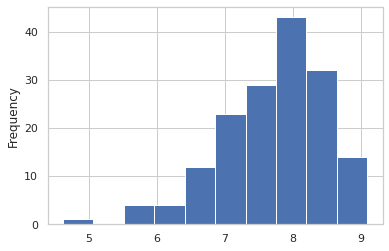

In [ ]:
the_titles_rated_10 = ratings_clean.merge(users_rated_all_10.title, how='inner', on='title')
the_titles_rated_10.groupby('title')['score'].mean().plot.hist()

##### Subset view of data

In [ ]:
ratings_clean.head()

,username,type,id,title,score,status
36,WeeabooKat,anime,10087,Fate/Zero,9,2
37,WeeabooKat,anime,11741,Fate/Zero 2nd Season,9,2
92,WeeabooKat,anime,37510,Mob Psycho 100 II,10,2
93,WeeabooKat,anime,17074,Monogatari Series: Second Season,9,2
112,WeeabooKat,anime,41899,Ore dake Haireru Kakushi Dungeon,4,2


In [ ]:
top_users = ratings_clean.groupby('username')['score'].count().sort_values(ascending=False)[:10]
top_movies = ratings_clean.groupby('id')['score'].count().sort_values(ascending=False)[:10]
ratings_subset = ratings_clean.join(top_users, how='inner', on='username', rsuffix='_r') \
						                  .join(top_movies, how='inner', on='id', rsuffix='_r')

pd.crosstab(ratings_subset.username, ratings_subset.id, ratings_subset.score, aggfunc=np.mean)

id,1535,16498,25777,30276,31964,32281,35760,38000,38524,40748
username,,,,,,,,,,
-Mitsukii,10.0,10.0,8.0,8.0,8.0,10.0,8.0,8.0,9.0,9.0
-Sonal-,9.0,8.0,7.0,6.0,7.0,6.0,7.0,7.0,8.0,7.0
Coolest1234D,NaN,NaN,NaN,9.0,8.0,NaN,NaN,9.0,NaN,8.0
HikariHime93,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
Jotaku97,9.0,8.0,8.0,10.0,10.0,10.0,9.0,10.0,9.0,9.0
SingleH,7.0,7.0,7.0,5.0,3.0,3.0,7.0,3.0,4.0,3.0
TaichouSenpai,10.0,9.0,9.0,10.0,8.0,8.0,8.0,9.0,9.0,9.0
Yogumunt,10.0,10.0,10.0,9.0,8.0,10.0,10.0,8.0,10.0,9.0
batsling1234,9.0,6.0,7.0,8.0,8.0,8.0,7.0,7.0,8.0,5.0


In [ ]:
top_users = ratings_clean.groupby('username')['score'].count().sort_values(ascending=False)[500:511]
top_movies = ratings_clean.groupby('id')['score'].count().sort_values(ascending=False)[500:511]
ratings_subset = ratings_clean.join(top_users, how='inner', on='username', rsuffix='_r') \
						                  .join(top_movies, how='inner', on='id', rsuffix='_r')

pd.crosstab(ratings_subset.username, ratings_subset.id, ratings_subset.score, aggfunc=np.mean)

id,392,1840,7088,13125,18247,24765,31704,35557,35847,36999,103851
username,,,,,,,,,,,
Daxonzion-,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
FIXXX,9.0,NaN,6.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
Galo_Jimenez,NaN,4.0,7.0,10.0,3.0,NaN,NaN,10.0,NaN,NaN,NaN
KingCodeMonkey,NaN,NaN,NaN,9.0,3.0,NaN,NaN,NaN,NaN,6.0,7.0
KisaragiRP,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,9.0,NaN
MrDonCaliche,NaN,NaN,NaN,7.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN
RadioactiveGhost,NaN,8.0,NaN,NaN,NaN,9.0,NaN,9.0,8.0,10.0,10.0
Rathesungod,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
i-have-a-problem,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN


##### User category

In [ ]:
# Do people that mostly watch anime, read less manga; vice versa

In [ ]:
type_per_users_count = pd.crosstab(ratings_clean['username'], ratings_clean['type'], ratings_clean['title'], aggfunc='count')
type_per_users_count.head()

type,anime,manga
username,,
---DANIEL---,48.0,6.0
---KING---,305.0,6.0
---Spartacus---,4.0,NaN
--ALEX--,854.0,70.0
--ANONYMOUS--,495.0,8.0


In [ ]:
type_per_users_count.isna().sum()

type
anime     103
manga    4829
dtype: int64

In [ ]:
type_per_users_count.fillna(value=0, inplace=True)

In [ ]:
type_per_users_count.shape

(17548, 2)

In [ ]:
type_per_users_count.describe()

type,anime,manga
count,17548.000000,17548.000000
mean,220.967119,35.803567
std,323.814024,140.701482
min,0.000000,0.000000
25%,57.000000,0.000000
50%,133.000000,5.000000
75%,268.000000,22.000000
max,11506.000000,4119.000000


In [ ]:
type_per_users_count['anime_proportion'] = type_per_users_count.anime / (type_per_users_count.anime + type_per_users_count.manga)
type_per_users_count['manga_proportion'] = type_per_users_count.manga / (type_per_users_count.anime + type_per_users_count.manga)

type_per_users_count.head()

type,anime,manga,anime_proportion,manga_proportion
username,,,,
---DANIEL---,48.0,6.0,0.888889,0.111111
---KING---,305.0,6.0,0.980707,0.019293
---Spartacus---,4.0,0.0,1.000000,0.000000
--ALEX--,854.0,70.0,0.924242,0.075758
--ANONYMOUS--,495.0,8.0,0.984095,0.015905


In [ ]:
def users_category(anime_proportion):
  if anime_proportion > .75:
    return 'anime'
  elif anime_proportion < .25:
    return 'manga'
  else:
    return 'balanced'

type_per_users_count['users_category'] = type_per_users_count.anime_proportion.apply(users_category)
type_per_users_count.head()

type,anime,manga,anime_proportion,manga_proportion,users_category
username,,,,,
---DANIEL---,48.0,6.0,0.888889,0.111111,anime
---KING---,305.0,6.0,0.980707,0.019293,anime
---Spartacus---,4.0,0.0,1.000000,0.000000,anime
--ALEX--,854.0,70.0,0.924242,0.075758,anime
--ANONYMOUS--,495.0,8.0,0.984095,0.015905,anime


In [ ]:
type_per_users_count.users_category.value_counts()

anime       15528
balanced     1801
manga         219
Name: users_category, dtype: int64

In [ ]:
type_per_users_count[type_per_users_count.users_category == 'balanced'].head()

type,anime,manga,anime_proportion,manga_proportion,users_category
username,,,,,
--FallenAngel--,473.0,485.0,0.493737,0.506263,balanced
--Tsubasa--,272.0,116.0,0.701031,0.298969,balanced
-606,109.0,43.0,0.717105,0.282895,balanced
-Ackerman,2205.0,1224.0,0.643045,0.356955,balanced
-Akiru-,162.0,54.0,0.750000,0.250000,balanced


In [ ]:
type_per_users_count[type_per_users_count.users_category == 'manga'].head()

type,anime,manga,anime_proportion,manga_proportion,users_category
username,,,,,
-1-2-3-4-5-,0.0,3.0,0.000000,1.000000,manga
-9AA,1.0,12.0,0.076923,0.923077,manga
-Accelerator94-,158.0,817.0,0.162051,0.837949,manga
-Astra-,0.0,2.0,0.000000,1.000000,manga
-BlackRabbit-,70.0,332.0,0.174129,0.825871,manga


In [ ]:
# Distribution amongst user category
anime_category = type_per_users_count[type_per_users_count.users_category == 'anime'].copy()
manga_category = type_per_users_count[type_per_users_count.users_category == 'manga'].copy()
balanced_category = type_per_users_count[type_per_users_count.users_category == 'balanced'].copy()

In [ ]:
anime_category.anime_proportion.mean(), anime_category.anime_proportion.std()

(0.9483302707782241, 0.062049306202936666)

In [ ]:
manga_category.manga_proportion.mean(), manga_category.manga_proportion.std()

(0.9183352320224013, 0.08955117954760677)

In [ ]:
balanced_category.anime_proportion.mean(), balanced_category.anime_proportion.std()

(0.5941022413706878, 0.129755262521461)

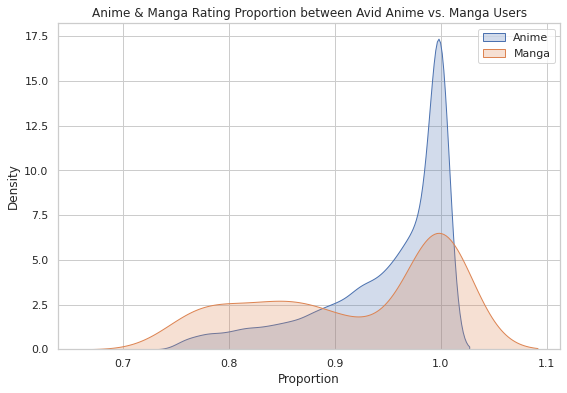

In [ ]:
# the group that watch anime, watch anime most of the time (like, anime-only)
# while the group that read manga, still watch some anime, some of the time.
sns.kdeplot(
    x = anime_category.anime_proportion,
    shade = True,
    label='Anime'
)

sns.kdeplot(
    x = manga_category.manga_proportion,
    shade = True,
    label='Manga'
)

plt.title('Anime & Manga Rating Proportion between Avid Anime vs. Manga Users')
plt.xlabel('Proportion')
plt.legend()

[Text(0.5, 0, 'Anime Proportion'),
 Text(0.5, 1.0, 'Anime & Manga Rating Proportion of Balanced Users')]

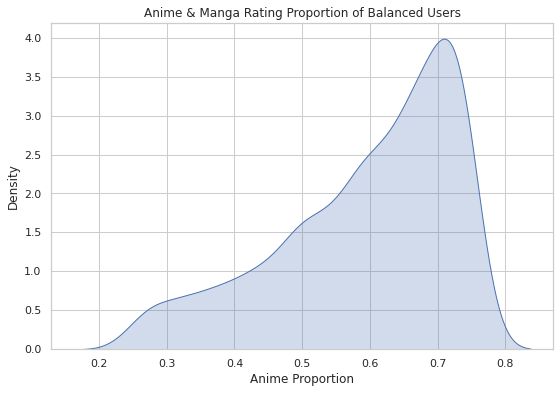

In [ ]:
# the balanced group steer more towards anime
sns.kdeplot(
    x = balanced_category.anime_proportion,
    shade = True
).set(title='Anime & Manga Rating Proportion of Balanced Users', xlabel='Anime Proportion')

In [ ]:
sum(anime_category.anime_proportion == 1), sum(manga_category.manga_proportion == 1)

(4829, 103)

In [ ]:
len(type_per_users_count) - 2412 - 46

15090

##### Type x status relationship

In [ ]:
status_per_type_count = pd.crosstab(ratings['type'], ratings['status'], ratings['title'], aggfunc='count')
status_per_type_count.head()

status,1,2,3,4,6
type,,,,,
anime,323025,4218440,241024,235725,2021825
manga,359518,530814,98599,48982,509941


[Text(0.5, 1.0, 'Status Comparison between Anime and Manga')]

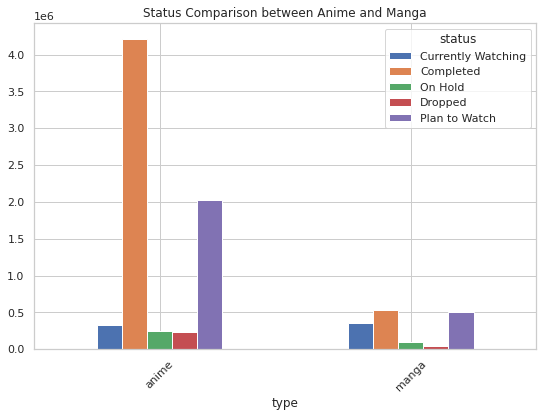

In [ ]:
# there are more plan-to-read in the manga space than actual completed manga,
# but, there are disproportionately more completed anime than planned-to-watch
# the rate of currently, hold, and dropped are about the same rate, I think.
map_index = {
    1: "Currently Watching",
    2: "Completed",
    3: "On Hold",
    4: "Dropped",
    6: "Plan to Watch",
}
status_per_type_count.rename(map_index, axis=1, inplace=True)
status_per_type_count.plot.bar(rot=45).set(title='Status Comparison between Anime and Manga')

##### Ratings-amounts relationship

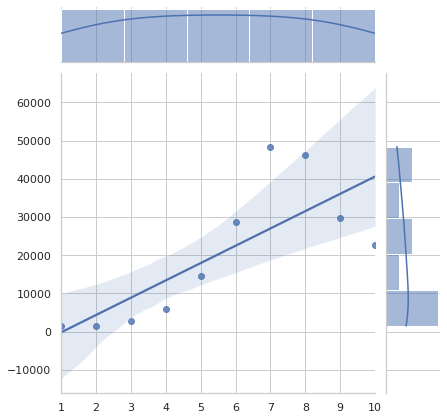

In [ ]:
m = manga.score.value_counts()
sns.jointplot(x=m.index, y=m.values, height=6, kind='reg')

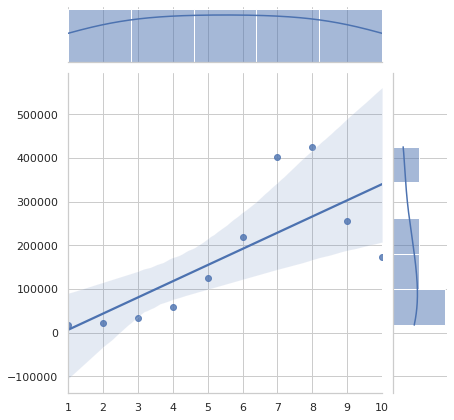

In [ ]:
a = anime.score.value_counts()
sns.jointplot(x=a.index, y=a.values, height=6, kind='reg')

##### Ratings per user per domain

In [ ]:
type_per_users_count.head()

type,anime,manga,anime_proportion,manga_proportion,users_category
username,,,,,
--ALEX--,890.0,119.0,0.882061,0.117939,anime
--Nightmare--,486.0,1.0,0.997947,0.002053,anime
--William--,202.0,5.0,0.975845,0.024155,anime
--Xerxes--,187.0,2.0,0.989418,0.010582,anime
-Arnheid-,121.0,56.0,0.683616,0.316384,balanced


In [ ]:
type_per_users_count.describe()

type,anime,manga,anime_proportion,manga_proportion
count,10071.000000,7705.000000,7659.000000,7659.000000
mean,330.602820,76.113173,0.873341,0.126659
std,464.613411,397.080170,0.151706,0.151706
min,1.000000,1.000000,0.007018,0.000455
25%,103.000000,5.000000,0.834312,0.026549
50%,215.000000,17.000000,0.927083,0.072917
75%,405.000000,58.000000,0.973451,0.165688
max,16467.000000,28019.000000,0.999545,0.992982


##### Quantile

In [ ]:
np.quantile(type_per_users_count.anime, [.2, .15, .1, .05, .025])

array([82., 63., 42., 17.,  6.])

In [ ]:
np.quantile(type_per_users_count.manga, [.2, .15, .1, .05, .025])

array([0., 0., 0., 0., 0.])

## Dumps

### Checking Filters

In [ ]:
ratings_clean.shape

(4505812, 6)

In [ ]:
type_per_users_count = pd.crosstab(ratings_clean['username'], ratings_clean['type'], ratings_clean['title'], aggfunc='count')
type_per_users_count.fillna(value=0, inplace=True)
type_per_users_count.head()

type,anime,manga
username,,
---DANIEL---,48.0,6.0
---KING---,305.0,6.0
---Spartacus---,4.0,0.0
--ALEX--,854.0,70.0
--ANONYMOUS--,495.0,8.0


In [ ]:
type_per_users_count['total_ratings'] = type_per_users_count.anime + type_per_users_count.manga
type_per_users_count['total_ratings'].quantile([.75, .5, .25, .15, .1, .05, .01])

0.75    305.00
0.50    147.00
0.25     62.00
0.15     34.00
0.10     19.00
0.05      6.35
0.01      1.00
Name: total_ratings, dtype: float64

In [ ]:
# users with total rating less than 10
len(type_per_users_count.loc[type_per_users_count['total_ratings'] < 10])

1104

In [ ]:
# users with total MANGA rating less than 10
len(type_per_users_count.loc[type_per_users_count['manga'] < 10])

10755

In [ ]:
# users with total ANIME rating less than 10
len(type_per_users_count.loc[type_per_users_count['anime'] < 10])

1237

In [ ]:
titles_rated = ratings_clean.groupby('title')['username'].count()
titles_rated.loc[titles_rated >= 10]

title
"0"                                               79
"Aishiteru", Uso dakedo.                          23
"Aoi" Hikaru ga Chikyuu ni Ita Koro......         47
"Boku wa Senpai ni Josou wo Shiirareteimasu."     27
"Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi        245
                                                ... 
◯                                                 64
♀x♀=♥                                             16
♂Docchi♀                                          11
♭37℃                                              11
♭38℃: Loveberry Twins♥                            16
Name: username, Length: 21473, dtype: int64

### Fixing the messed up IDs (before dumping)

In [ ]:
# some anime & manga have the same id...
ratings[ratings.id == 1].title.unique()

array(['Cowboy Bebop', 'Monster'], dtype=object)

In [ ]:
# trying to get the id for anime 0 ~ `last anime title`;
# while manga be `last anime title` + 1 ~ `last manga title`

In [ ]:
# create a new dataframe to work on before numbering
anime_df = ratings_clean.loc[ratings_clean['type'] == 'anime'].copy()
manga_df = ratings_clean.loc[ratings_clean['type'] == 'manga'].copy()

In [ ]:
# THIS! the ids are messed up when it's numbered through single-pass groupby,
# because several anime & manga titles are the same (2k of them, in fact.)
# and these made the same id are categorized in different type...
ratings_clean.title.nunique(), anime_df.title.nunique() + manga_df.title.nunique()

(47519, 49768)

In [ ]:
# this solves the problem. by first separating the type, and doing grouping on
# the separated dataframe, it works.
anime_id = anime_df.sort_values('id').groupby('title').ngroup()
offset_id = anime_id.max() + 1
manga_id = manga_df.sort_values('id').groupby('title').ngroup() + offset_id

anime_id.max(), manga_id.min(), manga_id.max()  # it's 0-indexed

(17050, 17051, 49767)

In [ ]:
anime_df['item'] = anime_id
manga_df['item'] = manga_id

anime_df.head()

,username,type,id,title,score,status,item
2298397,JBBeast,anime,12231,Dragon Ball: Episode of Bardock,1,2,3408
1068054,nightfury10,anime,38573,Tsuujou Kougeki ga Zentai Kougeki de Ni-kai Ko...,1,2,15412
1092096,AzzurroKurai97X,anime,32878,ēlDLIVE,1,2,17049
2960507,VhlleX,anime,32901,Eromanga-sensei,1,2,3666
3364426,Timelime,anime,21881,Sword Art Online II,1,2,14265


### Dump data

In [ ]:
# keep the id of rex' for later (personal) evaluation
# rex_chan_s' id = 8593
full_dump = pd.concat([anime_df, manga_df], ignore_index=True)
full_dump['user'] = full_dump.groupby('username').ngroup()

print(full_dump[full_dump.username == 'rex_chan_s'].user)

# also, dump the neat ratings with its full column
full_dump.drop(columns=['id'], inplace=True)
rearrange_columns = ['username', 'user', 'type', 'item', 'title', 'score', 'status']
full_dump = full_dump[rearrange_columns]

full_dump.to_csv('with_clubs_neat_ratings_full_column.csv', index=False)

473740     16611
906589     16611
1903411    16611
2037640    16611
2037650    16611
           ...  
4433047    16611
4433048    16611
4433049    16611
4433050    16611
4433051    16611
Name: user, Length: 82, dtype: int64


In [ ]:
!head 'neat_ratings_full_column.csv'

username,user,type,item,title,score,status
Yugi_Tsukasa,6143,anime,14968,Vanitas no Karte,1,4
Ed_warudo,1659,anime,6528,Kaifuku Jutsushi no Yarinaoshi,1,3
Superdooper224,5360,anime,6729,Kanojo wa Dare to demo Sex Suru.,1,6
SkyXPlay,5131,anime,6949,Ken to Mahou no Logres: Inishie no Megami x Fate/Extella,1,2
Random1234,4558,anime,1710,Buddy Go!,1,2
quiuzus,8518,anime,16135,◯,1,2
NamaloomShacks,3913,anime,4195,Generation of Chaos,1,2
blorf7,6688,anime,4850,Hametsu no Mars,1,2
ElPatoOtaku,1686,anime,10710,Overlord II,1,4


In [ ]:
# join the anime & manga df
df = pd.concat([anime_df, manga_df], ignore_index=True)

# create new user_id (the previous one uses username)
df['user'] = df.groupby('username').ngroup()

# drop unused columns
df.drop(columns=['username', 'id', 'title', 'status'], inplace=True)

# rename for clarity
df.rename(columns={'score': 'rating'}, inplace=True)

# rearrange the column
df = df[['type', 'user', 'item', 'rating']]

df.head()

,type,user,item,rating
0,anime,7463,3408,1
1,anime,16225,15412,1
2,anime,4054,17049,1
3,anime,11704,3666,1
4,anime,11454,14265,1


In [ ]:
# sanity check, lengths are the same
assert ratings_clean.shape[0] == df.shape[0]

In [ ]:
df.to_csv('with_clubs_neat_ratings.csv', index=False)